In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [ ]:
def position(theta, length):
    pos = np.array([np.sin(theta)*length, -np.cos(theta)*length]).T
    return pos

In [ ]:
def get_alpha(theta, length):
        return -9.81/length * np.sin(theta)

In [ ]:
def simple_euler(theta, omega, length, dt=1e-3):   
    alpha = get_alpha(theta, length)
    nomega = omega + alpha*dt
    # ntheta = (theta + nomega*dt) % (2*np.pi)
    ntheta = theta + nomega*dt
    return ntheta, nomega

In [ ]:
def runge_kutta_2(theta, omega, length, dt=1e-3):

    k1o = get_alpha(theta, length)
    k2o = get_alpha(theta+0.5*k1o*dt, length)    
    nomega = omega + k2o*dt

    k1t = nomega
    k2t = nomega + 0.5*k1t*dt
    ntheta = theta + k2t*dt

    return ntheta, nomega


In [ ]:
def runge_kutta_3(theta, omega, length, dt=1e-3):

    k1o = get_alpha(theta, length)
    k2o = get_alpha(theta+0.5*k1o*dt, length)
    k3o = get_alpha(theta+k1o*dt)    
    nomega = omega + (k1o + 4*k2o + k3o)*dt/6

    k1t = nomega
    k2t = nomega + 0.5*k1t*dt
    k3t = nomega + (2*k2t-k1t)*dt
    ntheta = theta + (k1t + 4*k2t + k3t)*dt/6

    return ntheta, nomega

In [ ]:
def simulate(theta_init, length, mass, dt=1e-3, num_steps=2000, step_fn=simple_euler):
    times = np.arange(num_steps)*dt
    pos = np.ndarray((num_steps, 2))
    theta_arr = np.zeros(num_steps)
    theta = theta_init
    omega = 0
    for t in range(num_steps):
        theta_arr[t] = theta
        pos[t] = position(theta, length)
        theta, omega = step_fn(theta, omega, length, dt)
    return times, pos, theta_arr

No handles with labels found to put in legend.


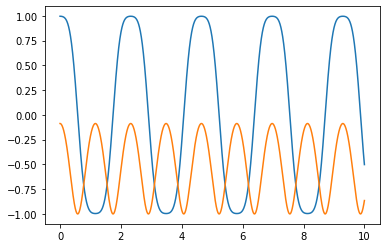

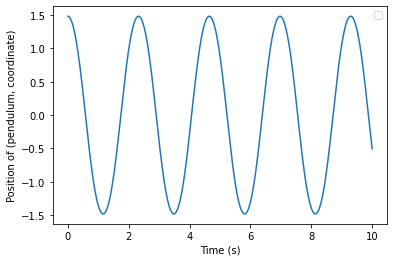

In [ ]:
# one-pendulum case
theta_init = np.pi / 180 * np.array([85])
length = 1
mass = 0.1

time, pos, theta_arr = simulate(theta_init, length, mass, num_steps=10000, step_fn=simple_euler)
plt.figure()
# plt.plot(time, theta_arr)
for i in range(2):
  plt.plot(time, pos[:, i], label="{0}".format(i))

time, pos, theta_arr = simulate(theta_init, length, mass, num_steps=10000, step_fn=runge_kutta_2)
plt.figure()
plt.plot(time, theta_arr)

# time, pos, theta_arr = simulate(theta_init, length, mass, num_steps=10000, step_fn=runge_kutta_3)
# plt.figure()
# plt.plot(time, theta_arr)


plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Position of (pendulum, coordinate)")
plt.show()